第7章 集成学习和随机森林
- 如果你聚合一组预测器（比如分类器或回归器）的预测，
- 得到的预测结果也比最好的单个预测器要好。
- 这样的一组预测器， 我们称为集成，
- 所以这种技术， 也被称为集成学习，
- 而一个集成学习的算法则被称为集成方法。

# 投票分类器

## 实验
- 假设你已经训练好了一些分类器， 每个分类器的准确率约为80%。
- 大概包括：
- 一个逻辑回归分类器、 
- 一个SVM分类器、 
- 一个随机
- 森林分类器、
- 一个K-近邻分类器，
- 或许还有更多

![](img/7-1.png)

- 这时， 要创建出一个更好的分类器，
- 最简单的办法就是聚合每个分类器的预测，
- 然后将得票最多的结果作为预测类别。
- 这种大多数投票分类器被称为硬投票分类器

![](img/7-2.png)

- 这个投票法分类器的准确率通常比集成中最好的分类器还要高。
- 事实上，即使每个分类器都是弱学习器（意味着它仅比随机猜测好一点），
- 通过集成依然可以实现一个强学习器（高准确率），
- 只要有足够大数量并且足够多种类的弱学习器就可以。

## 大数定理
- 假设你有一个略微偏倚的硬币，它有51%的可能正面数字朝上，49%的可能背面花朝上。
- 在1000次投掷后，大多数为正面朝上”的概率接近75%。投掷硬币的次数越多，这个概率越高（例如，投掷10000次后，这个概率攀升至97%）。
- 随着你不断投掷硬币，正面朝上的比率越来越接近于正面的概率（51%） 

![](img/7-3.png)

## 代码示例

### 硬投票法

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42, solver='liblinear')
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=10)
svm_clf = SVC(gamma="auto", random_state=42)

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


### 软投票法

- 如果所有分类器都能够估算出类别的概率（即有predict_proba（）方法），
- 那么你可以将概率在所有单个分类器上平均，
- 然后让Scikit-Learn给出平均概率最高的类别作为预测。这被称为软投票法。 
- 通常来说， 它比硬投票法的表现更优， 
- 因为它给予那些高度自信的投票更高的权重。
- 而所有你需要做的就是用voting="soft"代替voting="hard"，
- 并确保所有分类器都可以估算出概率。

In [5]:
log_clf = LogisticRegression(random_state=42, solver='liblinear')
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=10)
svm_clf = SVC(gamma="auto", random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# bagging和pasting

## 概念
- 还有另一种方法是每个预测器使用的算法相同，
- 但是在不同的训练集随机子集上进行训练。 采样时如果将样本放回，这种方法叫作bagging（bootstrap aggregating的缩写， 也叫自举汇聚法）；
- 采样时样本不放回，这种方法则叫用pasting。

![](img/7-4.png)

- 一旦预测器训练完成， 集成就可以通过简单地聚合所有预测器的预测， 来对新实例做出预测。
- 聚合函数通常是统计法（即最多数的预测好比硬投票分类器一样）用于分类，或是平均法用于回归。
- 每个预测器单独的偏差都高于在原始训练集上训练的偏差，
- 但是通过聚合，同时降低了偏差和方差。
- 总体来说，最终结果是，与直接在原始训练集上训练的单个预测器相比，
- 集成的偏差相近，但是方差更低。

## 代码示例

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

In [7]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=42,
                                                        splitter='best'),
      

In [8]:
y_pred = bag_clf.predict(X_test)

In [9]:
accuracy_score(y_test, y_pred)

0.912

In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.856

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    plt.plot(X[:,0][y==0], X[:, 1][y==0], 'yo')
    plt.plot(X[:,0][y==1], X[:, 1][y==1], 'bs')
    plt.xlim([axes[0], axes[1]])
    plt.ylim([axes[2], axes[3]])
    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16, rotation=0)
    
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

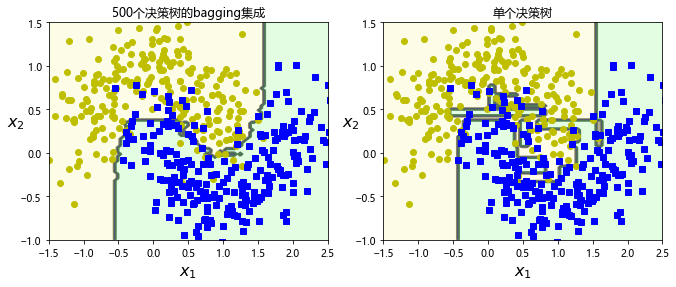

In [13]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title('500个决策树的bagging集成')
plot_decision_boundary(bag_clf, X, y)
plt.subplot(122)
plt.title('单个决策树')
plot_decision_boundary(tree_clf, X, y)

## 包外评估

- 对于任意给定的预测器， 使用bagging，
- 有些实例可能会被采样多次，而有些实例则可能根本不被采样。
- BaggingClassifier默认采样m个训练实例，然后放回样本（bootstrap=True），
- m是训练集的大小。
- 这意味着对于每个预测器来说， 平均只对63%的训练实例进行采样。剩余37%未被采样的训练实例称为包外（oob）实例。
- 注意，对所有预测器来说，这是不一样的37%。

- 既然预测器在训练的时候从未见过这些包外实例，
- 正好可以用这些实例进行评估， 从而不需要单独的验证集或是交叉验证。
- 将每个预测器在其包外实例上的评估结果进行平均， 你就可以得到对集成的评估

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [15]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

In [16]:
bag_clf.oob_decision_function_

array([[0.38502674, 0.61497326],
       [0.37195122, 0.62804878],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08064516, 0.91935484],
       [0.34517766, 0.65482234],
       [0.00540541, 0.99459459],
       [0.98941799, 0.01058201],
       [0.94915254, 0.05084746],
       [0.78651685, 0.21348315],
       [0.00552486, 0.99447514],
       [0.79347826, 0.20652174],
       [0.84816754, 0.15183246],
       [0.97536946, 0.02463054],
       [0.02325581, 0.97674419],
       [0.        , 1.        ],
       [0.97814208, 0.02185792],
       [0.94797688, 0.05202312],
       [1.        , 0.        ],
       [0.01522843, 0.98477157],
       [0.35025381, 0.64974619],
       [0.93406593, 0.06593407],
       [1.        , 0.        ],
       [0.96202532, 0.03797468],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62983425, 0.37016575],
       [0.

## Random Patches和随机子空间

- BaggingClassifier也支持对特征进行抽样，
- 这通过两个超参数控制：max_features和bootstrap_features。
- 它们的工作方式跟max_samples和bootstrap相同，
- 只是抽样对象不再是实例，而是特征。
- 因此，每个预测器将用输入特征的随机子集进行训练。

- 这对于处理高维输入（例如图像） 特别有用。
- 对训练实例和特征都进行抽样， 被称为Random Patches方法。
- 而保留所有训练实例（即bootstrap=False并且max_samples=1.0） 但是对特征进行抽样（即bootstrap_features=True并且/或max_features<1.0），这被称为随机子空间法。

# 随机森林

## 代码实现

- 随机森林是决策树的集成，
- 通常用bagging（有时也可能是pasting）方法训练，
- 训练集大小通过max_samples来设置。
- 除了先构建一个BaggingClassifier然后将结果传输到DecisionTreeClassifier，
- 还有一种方法就是使用RandomForestClassifier类，这种方法更方便，
- 对决策树更优化（同样，对于回归任务也有一个RandomForestRegressor类）。 

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42, splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bag)

0.912

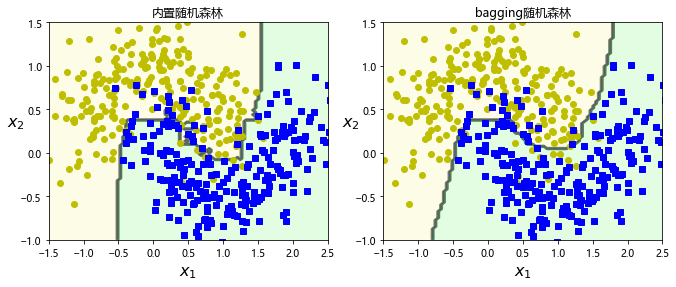

In [19]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title('内置随机森林')
plot_decision_boundary(rnd_clf, X, y)
plt.subplot(122)
plt.title('bagging随机森林')
plot_decision_boundary(bag_clf, X, y)

## 极端随机树

- 随机森林里单棵树的生长过程中，
- 每个节点在分裂时仅考虑到了一个随机子集所包含的特征。
- 如果我们对每个特征使用随机阈值，
- 而不是搜索得出的最佳阈值（如常规决策树），
- 则可能让决策树生长得更加随机。
- 这种极端随机的决策树组成的森林， 被称为极端随机树

- 使用Scikit-Learn的ExtraTreesClassifier可以创建一个极端随机树分类器。
- 它的API与RandomForestClassifier相同。
- 同理，ExtraTreesRegressor与RandomForestRegressor的API也相同。

- 通常来说，很难预先知道一个RandomForestClassifier是否会比一个ExtraTreesClassifier更好或是更差。
- 唯一的方法是两种都尝试一遍， 然后使用交叉验证（还需要使用网格搜索调整超参数） 进行比较

## 特征重要性
- 最后，如果你查看单个决策树会发现，
- 重要的特征更可能出现在靠近根节点的位置，
- 而不重要的特征通常出现在靠近叶节点的位置（甚至根本不出现）。
- 因此，通过计算一个特征在森林中所有树上的平均深度，
- 可以估算出一个特征的重要程度。

### 示例

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


- 输出了每个特征的重要性。
- 看起来最重要的特征是花瓣长度（44%）和宽度（42%），
- 而花萼的长度和宽度则相对不那么重要（分别是11%和2%）

- 如果你在MNIST数据集（见第3章） 上训练一个随机森林分类器， 然后绘制其每个像素的重要性

![](img/7-6.png)

# 提升法

## AdaBoost

### 概述
- 新预测器对其前序进行纠正的办法之一，
- 就是更多地关注前序拟合不足的训练实例。
- 从而使新的预测器不断地越来越专注于难缠的问题，
- 这就是AdaBoost使用的技术。

- 例如，要构建一个AdaBoost分类器，
- 首先需要训练一个基础分类器（比如决策树），
- 用它对训练集进行预测。
- 然后对错误分类的训练实例增加其相对权重，
- 接着，使用这个最新的权重对第二个分类器进行训练，
- 然后再次对训练集进行预测，继续更新权重， 并不断循环向前

![](img/7-7.png)

- 第一个分类器产生了许多错误实例， 所以这些实例的权重得到提升。
- 因此第二个分类器在这些实例上的表现有所提升，
- 然后第三个、第四个……右图绘制的是相同预测器序列，
- 唯一的差别在于学习率减半（即每次迭代仅提升一半错误分类的实例的权重）。
- 可以看出，AdaBoost这种依序循环的学习技术跟梯度下降有一些异曲同工之处，
- 差别只在于——不再是调整单个预测器的参数使成本函数最小化，
- 而是不断在集成中加入预测器， 使模型越来越好。

<small>这种依序学习技术有一个重要的缺陷就是无法并行（哪怕只是一部分） ， 因为每个预测器只能在前一个预测器训练完成并评估之后才能开始训练。 因此， 在拓展方面， 它的表现不如bagging和pasting方法。</small>

In [21]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [22]:
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

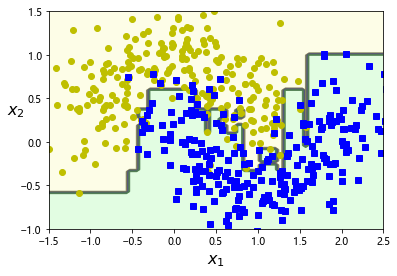

In [23]:
plot_decision_boundary(ada_clf, X, y)

- 练习预测器决策边界

![](img/7-8.png)

### 数学推导
- 第j个预测器的加权误差率
$$ r_j=\frac{\sum_{i=1}^mw^{(i)}}{\sum_{i=1}^mw^{(i)}} $$
- 预测器权重
$$\alpha_j=\eta log\frac{1-r_j}{r_j}$$
- 权重更新规则
$$  w^{(i)}\leftarrow\begin{cases}
w^{(i)} & (\hat{y_j}^{(i)}=y^{(i)}) \\
w^{(i)}exp(\alpha_j) & (\hat{y_j}^{(i)}\neq y^{(i)})
\end{cases} $$
- 然后将所有实例的权重归一化（即除以$ \sum_{i=1}^mw^{(i)} $） 。
- 最后，使用更新后的权重训练一个新的预测器，然后重复整个过程（计算新预测器的权重， 更新实例权重，然后对另一个预测器进行训练，等等）。当到达所需数量的预测器，或得到完美的预测器时，算法停止。

- 预测的时候， AdaBoost就是简单地计算所有预测器的预测结果，
- 并使用预测器权重αj对它们进行加权。 
- 最后， 得到大多数加权投票的类别就是预测器给出的预测类别

- AdaBoost预测
$$ \hat{y}(X)=argnax_k\sum_{j=1}^N\alpha_j $$
$$ \hat{y}_j(X)=k $$

### 代码示例

- Scikit-Learn使用的其实是AdaBoost的一个多分类版本， 叫作SAMME（基于多类指数损失函数的逐步添加模型）。
- 当只有两个类别时，SAMME即等同于AdaBoost。
- 此外，如果预测器可以估算类别概率（即具有predict_proba（）方法），
- Scikit-Learn会使用一种SAMME的变体，称为SAMME.R（R代表“Real”），
- 它依赖的是类别概率而不是类别预测， 通常表现更好。

In [24]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [25]:
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

## 梯度提升

- 梯度提升也是逐步在集成中添加预测器，
- 每一个都对其前序做出改正。
- 不同之处在于， 它不是像AdaBoost那样在每个迭代中调整实例权重，
- 而是让新的预测器针对前一个预测器的残差进行拟合。

### 代码示例

- 首先，在训练集（比如带噪声的二次训练集）上拟合一个DecisionTreeRegressor

In [26]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [27]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

- 现在，针对第一个预测器的残差，训练第二个DecisionTreeRegressor：

In [28]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

- 然后， 针对第二个预测器的残差，训练第三个回归器：

In [29]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

- 现在， 我们有了一个包含三棵树的集成。 它将所有树的预测相加， 从而对新实例进行预测：

In [30]:
X_new = np.array([[0.8]])

In [31]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [32]:
y_pred

array([0.75026781])

- 训练GBRT集成有个简单的方法， 就是使用Scikit-Learn的GradientBoosting-Regressor类。 

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
y_pred = gbrt.predict(X_new)
y_pred

array([0.75026781])

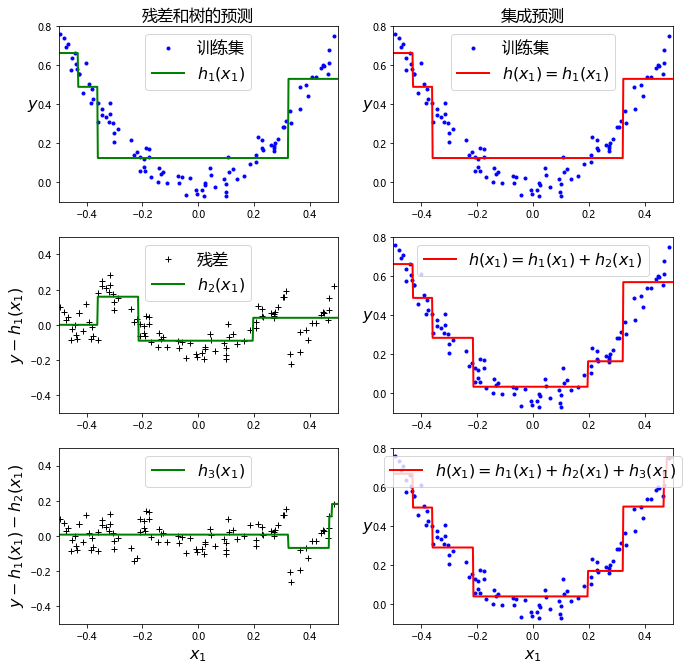

In [35]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="训练集")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("残差和树的预测", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="训练集")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("集成预测", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="残差")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

- 超参数learning_rate对每棵树的贡献进行缩放。如果你将其设置为低值，比如0.1，则需要更多的树来拟合训练集，但是预测的泛化效果通常更好。 

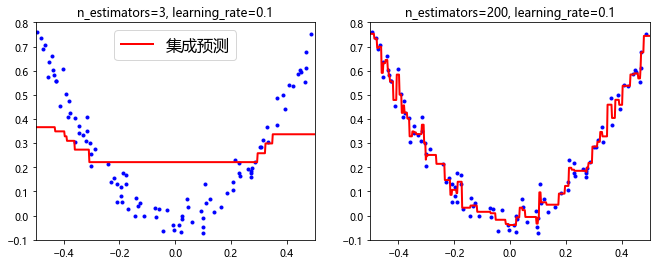

In [38]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.title('n_estimators=3, learning_rate=0.1')
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='集成预测')
plt.subplot(122)
plt.title('n_estimators=200, learning_rate=0.1')
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

- 预测器太少（左图） 和预测器太多（右图）

- 要找到树的最佳数量，可以使用早期停止法（参见第4章）。
- 简单的实现方法就是使用staged_predict（）方法：
- 它在训练的每个阶段（一棵树时，两棵树时，等等）都对集成的预测返回一个迭代器。
- 以下代码训练了一个拥有120棵树的GBRT集成，
- 然后测量每个训练阶段的验证误差，
- 从而找到树的最优数量，
- 最后使用最优树数重新训练了一个GBRT集成：

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [43]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimator = np.argmin(errors)

In [44]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimator, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=67,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
min_error = np.min(errors)
bst_n_estimator, min_error

(67, 0.0030248830463853182)

Text(0.5, 1.0, '最好的模型（67棵树）')

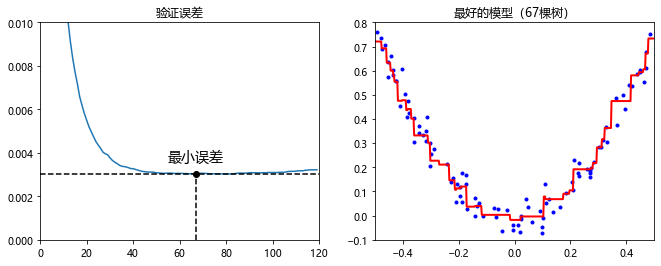

In [62]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(errors)
plt.title('验证误差')
plt.ylim(0, 0.01)
plt.xlim(0, 120)
plt.plot([bst_n_estimator, bst_n_estimator], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimator, min_error, "ko")
plt.text(bst_n_estimator, min_error*1.2, "最小误差", ha="center", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5,0.5,-0.1,0.8])
plt.title('最好的模型（67棵树）')

- 实际上， 要实现早期停止法，
- 不一定需要先训练大量的树， 然后再回头找最优的数字，
- 还可以真的提前停止训练。
- 设置warm_start=True，当fit（）方法被调用时，
- Scikit-Learn会保留现有的树，从而允许增量训练。 

In [66]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

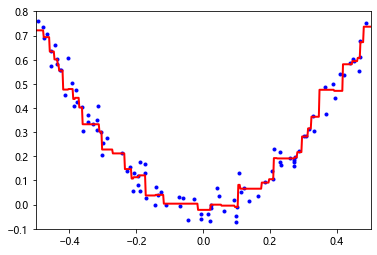

In [69]:
plot_predictions([gbrt], X, y, axes=[-0.5,0.5,-0.1,0.8])

# 折叠法
- 又称层叠泛化法
- 它基于一个简单的想法：
- 与其使用一些简单的函数（比如硬投票）来聚合集成中所有预测器的预测，
- 我们为什么不训练一个模型来执行这个聚合呢？ 
- 图7-12显示了在新实例上执行回归任务的这样一个集成。
- 底部的三个预测器分别预测了不同的值（3.1、 2.7和2.9），
- 然后最终的预测器（称为混合器或元学习器）将这些预测作为输入，进行最终预测（3.0） 。

![](img/7-12.png)

- 训练混合器的常用方法是使用留存集。
- 我们看看它是如何工作的。
- 首先，将训练集分为两个子集，第一个子集用来训练第一层的预测器。

![](img/7-13.png)

- 然后， 用第一层的预测器在第二个（留存） 子集上进行预测。
- 因为预测器在训练时从未见过这些实例，所以可以确保预测是“干净的”。
- 那么现在对于留存集中的每个实例都有了三个预测值。
- 我们可以使用这些预测值作为输入特征，创建一个新的训练集（新的训练集有三个维度），并保留目标值。
- 在这个新的训练集上训练混合器， 让它学习根据第一层的预测来预测目标值。

![](img/7-14.png)

- 事实上， 通过这种方法可以训练多种不同的混合器（例如， 一个使用线性回归， 另一个使用随机森林回归， 等等） ： 于是我们可以得到一个混合器层。
- 诀窍在于将训练集分为三个子集：
- 第一个用来训练第一层，
- 第二个用来创造训练第二层的新训练集（使用第一层的预测），
- 而第三个用来创造训练第三层的新训练集（使用第二层的预测）。
- 一旦训练完成， 我们可以按照顺序遍历每层来对新实例进行预测，

![](img/7-15.png)

- 不幸的是， Scikit-Learn不直接支持堆叠， 但是自己堆出stacking的实现品并不太难。 
- 或者， 你也可以使用开源的实现方案， 例如brew（可从https://github.com/viisar/brew)